<a href="https://colab.research.google.com/github/chuktuk/Amazon_Customer_Data/blob/master/Video_Games_Flair_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Switch to TPU and high RAM before running.

In [0]:
# import packages
import pandas as pd
from collections import defaultdict, deque
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

In [2]:
!pip install flair

In [3]:
# import flair
from flair.models import TextClassifier
classifier = TextClassifier.load('en-sentiment')
from flair.data import Sentence

2020-02-25 00:59:27,176 loading file /root/.flair/models/imdb-v0.4.pt


In [5]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz

--2020-02-24 23:56:49--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  11.2MB/s    in 13s     

2020-02-24 23:57:02 (11.1 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]



In [0]:
# read in the data
vg = pd.read_json('Video_Games_5.json.gz', lines=True, compression='gzip')

In [5]:
vg.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [0]:
# slice the appropriate columns
vg = vg.loc[:,['overall', 'reviewText']]

In [0]:
# clean up nan values and change datatype
vg = vg.dropna(how='any')
vg.loc[:,'overall'] = vg.overall.astype('int16')

In [0]:
# map sentiment for two-class pretrained model
vg.loc[:,'pt_sentiment'] = vg.overall.map({1: 0, 2: 0, 3: 1, 4: 1, 5: 1}).astype('int16')

In [9]:
# inspect the df info
vg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497419 entries, 0 to 497576
Data columns (total 3 columns):
overall         497419 non-null int16
reviewText      497419 non-null object
pt_sentiment    497419 non-null int16
dtypes: int16(2), object(1)
memory usage: 9.5+ MB


In [10]:
# get sentiment counts
vg.pt_sentiment.value_counts()

1    442407
0     55012
Name: pt_sentiment, dtype: int64

In [0]:
# split the data into train/test
train_text, test_text, train_labels, test_labels = train_test_split(vg.reviewText, 
                                                                    vg.pt_sentiment, 
                                                                    test_size=0.25,
                                                                    random_state=42, 
                                                                    stratify=vg.pt_sentiment)

In [0]:
# split the train data into train/valid
train_text, valid_text, train_labels, valid_labels = train_test_split(train_text, train_labels, 
                                                                      test_size=0.25,
                                                                      random_state=42, 
                                                                      stratify=train_labels)

In [18]:
# split the data into smaller chunks
# a list of your sentences
# sentences = [Sentence(text) for text in test_text]
sentences1 = deque()
sentences2 = deque()
sentences3 = deque()
sentences4 = deque()
sentences5 = deque()
test_text1 = test_text[:25000] # trying smaller size to save memory
test_text2 = test_text[25000:50000]
test_text3 = test_text[50000:75000]
test_text4 = test_text[75000:100000]
test_text5 = test_text[100000:]
print(len(test_text1) + len(test_text2) + len(test_text3) + len(test_text4) + len(test_text5))
print(len(test_text))

124355
124355


In [0]:
# extract the first chunk
for text in test_text1:
    sentences1.append(Sentence(text))

In [0]:
def get_pretrained_preds(sentences):
    
    # initialize values for loop
    scores = defaultdict(float)
    values = defaultdict(str)
    i = 0
    
    # predict for all sentences
    classifier.predict(sentences, mini_batch_size=32)
    
    # loop and store predictions
    # for sentence in sentences:
    #     scores[i] = sentence.labels[0].score
    #     values[i] = sentence.labels[0].value
    #     i+=1
    while len(sentences) > 0:
        sentence = sentences.popleft()
        scores[i] = sentence.labels[0].score
        values[i] = sentence.labels[0].value
        i+=1
        
    
    # create and return a dataframe
    df = pd.DataFrame({'probability': scores, 'prediction': values})
    return(df)

In [0]:
df_pred1 = get_pretrained_preds(sentences1)

In [22]:
df_pred1.head()

,probability,prediction
0,0.996104,POSITIVE
1,0.863034,POSITIVE
2,0.999872,POSITIVE
3,0.674651,POSITIVE
4,0.999235,NEGATIVE


In [23]:
df_pred1.shape

(25000, 2)

In [0]:
df_pred1.loc[:, 'pred'] = df_pred1.prediction.map({'POSITIVE': 1, 'NEGATIVE': 0})

In [26]:
df_pred1.head()

,probability,prediction,pred
0,0.996104,POSITIVE,1
1,0.863034,POSITIVE,1
2,0.999872,POSITIVE,1
3,0.674651,POSITIVE,1
4,0.999235,NEGATIVE,0


In [32]:
# get variables to test the accuracy
y_true1 = test_labels[:25000,]
y_pred1 = df_pred1.loc[:25000, 'pred']
print(y_true1.shape)
print(y_pred1.shape)

(25000,)
(25000,)


In [33]:
# print the confusion matrix
print(confusion_matrix(y_true1, y_pred1))
tn, fp, fn, tp = confusion_matrix(y_true1, y_pred1).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

[[ 2060   681]
 [ 5285 16974]]
True Negatives: 2060
False Positives: 681
False Negatives: 5285
True Positives: 16974
Detection Rate: 0.7625679500426794
False Positive Rate: 0.24844947099598685


In [34]:
print(classification_report(y_true1, y_pred1))

              precision    recall  f1-score   support

           0       0.28      0.75      0.41      2741
           1       0.96      0.76      0.85     22259

    accuracy                           0.76     25000
   macro avg       0.62      0.76      0.63     25000
weighted avg       0.89      0.76      0.80     25000



In [0]:
import matplotlib.pyplot as plt

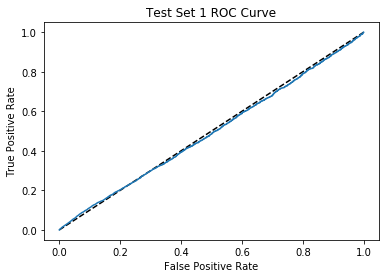

In [39]:
y_pred_prob = df_pred1.probability

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true1, df_pred1.probability)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='test_set_1')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Test Set 1 ROC Curve')

In [40]:
# compute the AUC
print(roc_auc_score(y_true1, y_pred_prob))

0.49359414510466393


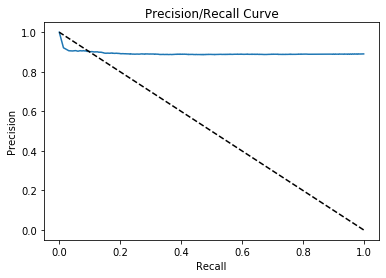

In [41]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(y_true1, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

In [0]:
df_pred1.to_csv('predictions.txt', sep=',', columns=['probability', 'prediction', 'pred'], 
                header=True, index=True, mode='w')

In [0]:
# extract the next chunk
for text in test_text2:
    sentences2.append(Sentence(text))

In [0]:
df_pred2 = get_pretrained_preds(sentences2)

In [0]:
df_pred2.to_csv('predictions.txt', sep=',', columns=['probability', 'prediction'], header=False, index=True, mode='a')

In [56]:
train_text.index[:10]

Int64Index([67189, 409345, 200528, 285828, 432542, 409749, 475246, 406743,
            17662, 183961],
           dtype='int64')

In [57]:
train_labels.index[:10]

Int64Index([67189, 409345, 200528, 285828, 432542, 409749, 475246, 406743,
            17662, 183961],
           dtype='int64')

In [61]:
train_text[67189]

'This is such a great game and I love having it back.  Works perfectly and I have no complaint.'

In [62]:
train_labels[67189]

1

In [64]:
for idx in train_text.index.values[:10]:
    print(idx)

67189
409345
200528
285828
432542
409749
475246
406743
17662
183961


In [0]:
# manual model training

In [0]:
# write to file instead of to long text string
import os.path

idxs = train_text.index.values
max_idx = max(idxs)

if os.path.isfile('train.txt'):
    print ("File already created.")
else:
    with open('train.txt', 'w') as file:
        for idx in idxs:
            line = '__label__'
            line += str(train_labels[idx]) + ' '
            line += str.replace(train_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [0]:
# write dev.txt
max_idx = max(valid_text.index.values)

if os.path.isfile('dev.txt'):
    print ("File already created.")
else:
    with open('dev.txt', 'w') as file:
        for idx in valid_text.index.values:
            line = '__label__'
            line += str(valid_labels[idx]) + ' '
            line += str.replace(valid_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [0]:
# write to file instead of to long text string
import os.path

max_idx = max(test_text.index.values)

if os.path.isfile('test.txt'):
    print ("File already created.")
else:
    with open('test.txt', 'w') as file:
        for idx in test_text.index.values:
            line = '__label__'
            line += str(test_labels[idx]) + ' '
            line += str.replace(test_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [0]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.trainers import ModelTrainer
from pathlib import Path

In [72]:
# load corpus containing training, test and dev data
corpus: Corpus = ClassificationCorpus('./',
                                      test_file='test.txt',
                                      dev_file='dev.txt',
                                      train_file='train.txt')

2020-02-25 04:20:23,794 Reading data from .
2020-02-25 04:20:23,796 Train: train.txt
2020-02-25 04:20:23,797 Dev: dev.txt
2020-02-25 04:20:23,798 Test: test.txt


In [0]:
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings
from flair.embeddings import FlairEmbeddings, DocumentRNNEmbeddings
from typing import List

In [74]:
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), 
                   FlairEmbeddings('news-backward-fast')]

2020-02-25 04:21:28,176 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmp191l1hro


100%|██████████| 160000128/160000128 [00:08<00:00, 18748517.45B/s]

2020-02-25 04:21:37,405 copying /tmp/tmp191l1hro to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2020-02-25 04:21:37,709 removing temp file /tmp/tmp191l1hro
2020-02-25 04:21:39,501 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmpwimu89tt


100%|██████████| 21494764/21494764 [00:01<00:00, 13379789.12B/s]

2020-02-25 04:21:41,645 copying /tmp/tmpwimu89tt to cache at /root/.flair/embeddings/glove.gensim
2020-02-25 04:21:41,673 removing temp file /tmp/tmpwimu89tt



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2020-02-25 04:21:43,338 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpp3a863t4


100%|██████████| 19689779/19689779 [00:01<00:00, 11843548.11B/s]

2020-02-25 04:21:45,568 copying /tmp/tmpp3a863t4 to cache at /root/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt
2020-02-25 04:21:45,607 removing temp file /tmp/tmpp3a863t4


2020-02-25 04:21:46,399 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp82vfokyo


100%|██████████| 19689779/19689779 [00:01<00:00, 11387038.61B/s]

2020-02-25 04:21:48,663 copying /tmp/tmp82vfokyo to cache at /root/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt
2020-02-25 04:21:48,689 removing temp file /tmp/tmp82vfokyo


In [0]:
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=512, 
                                             reproject_words=True, reproject_words_dimension=256)

In [0]:
classifier = TextClassifier(document_embeddings, 
                            label_dictionary=corpus.make_label_dictionary(), 
                            multi_label=False)

2020-02-25 04:26:50,415 Computing label dictionary. Progress:




  0%|          | 0/279798 [00:00<?, ?it/s]

  0%|          | 97/279798 [00:00<04:49, 964.81it/s]

  0%|          | 219/279798 [00:00<04:35, 1015.62it/s]

  0%|          | 350/279798 [00:00<04:16, 1088.22it/s]

  0%|          | 460/279798 [00:00<04:24, 1055.17it/s]

  0%|          | 562/279798 [00:00<04:29, 1036.02it/s]

  0%|          | 699/279798 [00:00<04:10, 1116.27it/s]

  0%|          | 849/279798 [00:00<03:51, 1205.95it/s]

  0%|          | 975/279798 [00:00<03:49, 1213.16it/s]

  0%|          | 1094/279798 [00:00<03:59, 1163.31it/s]

  0%|          | 1252/279798 [00:01<03:40, 1261.43it/s]

  1%|          | 1402/279798 [00:01<03:30, 1323.85it/s]

  1%|          | 1549/279798 [00:01<03:24, 1362.51it/s]

  1%|          | 1709/279798 [00:01<03:15, 1424.56it/s]

  1%|          | 1854/279798 [00:01<03:21, 1379.56it/s]

  1%|          | 2019/279798 [00:01<03:11, 1450.29it/s]

  1%|          | 2167/279798 [00:01<03:18, 1401.66it/s]

  1%|          | 2309/279798 [00:01<03:28, 1329.12it

In [0]:
trainer = ModelTrainer(classifier, corpus)

In [0]:
trainer.train('./', max_epochs=10)